Se debe descargar el dataset del enlace https://www.kaggle.com/datasets/prepinstaprime/black-friday-sales-data

# Exploración y limpieza

In [119]:
# preprocessing
import pandas
import numpy

# visualization
from matplotlib import pyplot
import seaborn

# machine learing
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Normalizer

# deep learning
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset


In [120]:
sales_df = pandas.read_csv("./train.csv")

In [121]:
sales_df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [122]:
print("Dimensiones del dataset:\n")
print(sales_df.shape)
print("\nTipos de las columnas y cantidad de valores únicos:\n")

column_types = sales_df.dtypes
uniques = sales_df.nunique()

column_summary = pandas.concat([column_types, uniques], axis=1, keys=["dtype", "uniques"])

print(column_summary)

Dimensiones del dataset:

(550068, 12)

Tipos de las columnas y cantidad de valores únicos:

                              dtype  uniques
User_ID                       int64     5891
Product_ID                   object     3631
Gender                       object        2
Age                          object        7
Occupation                    int64       21
City_Category                object        3
Stay_In_Current_City_Years   object        5
Marital_Status                int64        2
Product_Category_1            int64       20
Product_Category_2          float64       17
Product_Category_3          float64       15
Purchase                      int64    18105


Observamos que el dataset no presenta columna de tipo identificador único, que las columnas `Gender`, `Age`, `City_Category` y `Stay_In_Current_City_Years` son categóricas de tipo objecto (string) y que `Occupation` y `Marital_Status` son categóricas codificadas como entero.


Conteo absoluto y porcentual de valores nulos por columna.

In [123]:
nan_counts = sales_df.isnull().sum()
nan_pct = round(nan_counts / len(sales_df), 2)

nan_summary = pandas.concat([nan_counts, nan_pct], axis=1, keys=["count", "pct"])

print(nan_summary)

                             count   pct
User_ID                          0  0.00
Product_ID                       0  0.00
Gender                           0  0.00
Age                              0  0.00
Occupation                       0  0.00
City_Category                    0  0.00
Stay_In_Current_City_Years       0  0.00
Marital_Status                   0  0.00
Product_Category_1               0  0.00
Product_Category_2          173638  0.32
Product_Category_3          383247  0.70
Purchase                         0  0.00


Sólo las columnas `Product_Category_2` y `Product_Category_3` tienen valores nulos, 173.638 y 383.247, lo que representa un 32% y un 70% de valores nulos sobre el total de los datos, respectivamente.

In [124]:
sales_df.duplicated().sum()

0

El dataset no presenta columnas duplicadas.

In [125]:
print("Valores únicos de las columnas Product_Category 1, 2 y 3:\n")

print("Product_Category_1")
print(sorted(sales_df['Product_Category_1'].unique()))

print("Product_Category_2")
print(sorted(sales_df['Product_Category_2'].unique()))

print("Product_Category_3")
print(sorted(sales_df['Product_Category_3'].unique()))


Valores únicos de las columnas Product_Category 1, 2 y 3:

Product_Category_1
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Product_Category_2
[nan, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0]
Product_Category_3
[nan, 3.0, 4.0, 5.0, 6.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0]


Como vimos antes, ProdCat1 es de tipo entero y no tiene valores nulos, mientras que ProdCat2 y ProdCat3 son de tipo flotante y sí tiene valores nulos.

los valores de ProdCat1 van del 1 al 20;
los de ProdCat 2, del 2 al 18;
los de ProdCat 3, del 3 al 18 (saltándose el 7).

In [126]:
condition_a = sales_df['Product_Category_2'].isnull() & sales_df['Product_Category_3'].notnull()
all_nulls_in_2_are_null_in_3 = not condition_a.any()

condition_b = sales_df['Product_Category_3'].isnull() & sales_df['Product_Category_2'].notnull()
all_nulls_in_3_are_null_in_2 = not condition_b.any()

print("¿Todos los nulos en Product_Category_2 son también nulos en Product_Category_3?")
print(all_nulls_in_2_are_null_in_3)

print("¿Todos los nulos en Product_Category_3 son también nulos en Product_Category_2?")
print(all_nulls_in_3_are_null_in_2)

¿Todos los nulos en Product_Category_2 son también nulos en Product_Category_3?
True
¿Todos los nulos en Product_Category_3 son también nulos en Product_Category_2?
False


In [127]:
# Tabla cruzada de valores nulos
crosstab = pandas.crosstab(sales_df['Product_Category_2'].isnull(), sales_df['Product_Category_3'].isnull(), rownames=['2 is null'], colnames=['3 is null'])
print(crosstab)

3 is null   False   True 
2 is null                
False      166821  209609
True            0  173638


In [128]:
null_pc2 = sales_df['Product_Category_2'].isnull().astype(int)
null_pc3 = sales_df['Product_Category_3'].isnull().astype(int)

# Calcular la correlación
correlation = null_pc2.corr(null_pc3)
print(f"Correlación entre los nulos de ProdCat2 y ProdCat3: {round(correlation, 2)}")

Correlación entre los nulos de ProdCat2 y ProdCat3: 0.45


# Preprocesamiento

Creamos una copia del DataFrame para realizar el preprocesamiento sobre éste sin modificar al objeto original.

In [129]:
cleaned_sales = sales_df.copy()

Codificamos las varibales categóricas en valores numéricos.

In [130]:
def generate_map(unique_values):
    return {value: idx for idx, value in enumerate(unique_values)}

In [131]:
gender_uniques = sales_df['Gender'].unique()
age_uniques = sorted(sales_df['Age'].unique())
city_uniques = sorted(sales_df['City_Category'].unique())
stay_in_city_uniques = sorted(sales_df['Stay_In_Current_City_Years'].unique())

gender_map = generate_map(gender_uniques)
age_map = generate_map(age_uniques)
city_map = generate_map(city_uniques)
stay_in_city_map = generate_map(stay_in_city_uniques)

print(gender_map)
print(age_map)
print(city_map)
print(stay_in_city_map)

{'F': 0, 'M': 1}
{'0-17': 0, '18-25': 1, '26-35': 2, '36-45': 3, '46-50': 4, '51-55': 5, '55+': 6}
{'A': 0, 'B': 1, 'C': 2}
{'0': 0, '1': 1, '2': 2, '3': 3, '4+': 4}


In [132]:
cleaned_sales['Gender'] = sales_df['Gender'].map(gender_map)
cleaned_sales['Age'] = sales_df['Age'].map(age_map)
cleaned_sales['City_Category'] = sales_df['City_Category'].map(city_map)
cleaned_sales['Stay_In_Current_City_Years'] = sales_df['Stay_In_Current_City_Years'].map(stay_in_city_map)

Verificamos que el Product_ID de todos los registros cumpla con la forma “carácter ´P´ seguido de dígitos (0-9)”.

In [133]:
cumple_formato = sales_df['Product_ID'].str.match(r'^P\d+$').all()

print(cumple_formato)

True


Como se cumple la condición, eliminamos la "P" y convertimos el valor a entero.

In [134]:
cleaned_sales['Product_ID'] = sales_df['Product_ID'].str[1:].astype('int64')

In [135]:
cleaned_sales.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,69042,0,0,10,0,2,0,3,NaN,NaN,8370
1,1000001,248942,0,0,10,0,2,0,1,6.0,14.0,15200
2,1000001,87842,0,0,10,0,2,0,12,NaN,NaN,1422
3,1000001,85442,0,0,10,0,2,0,12,14.0,NaN,1057
4,1000002,285442,1,6,16,2,4,0,8,NaN,NaN,7969


Analizamos los valores de las columnas `Product_Category_2` y `Product_Category_3` para realizar tratamiento de valores faltantes.

In [136]:
columns_with_missing_values = ['Product_Category_2', 'Product_Category_3']

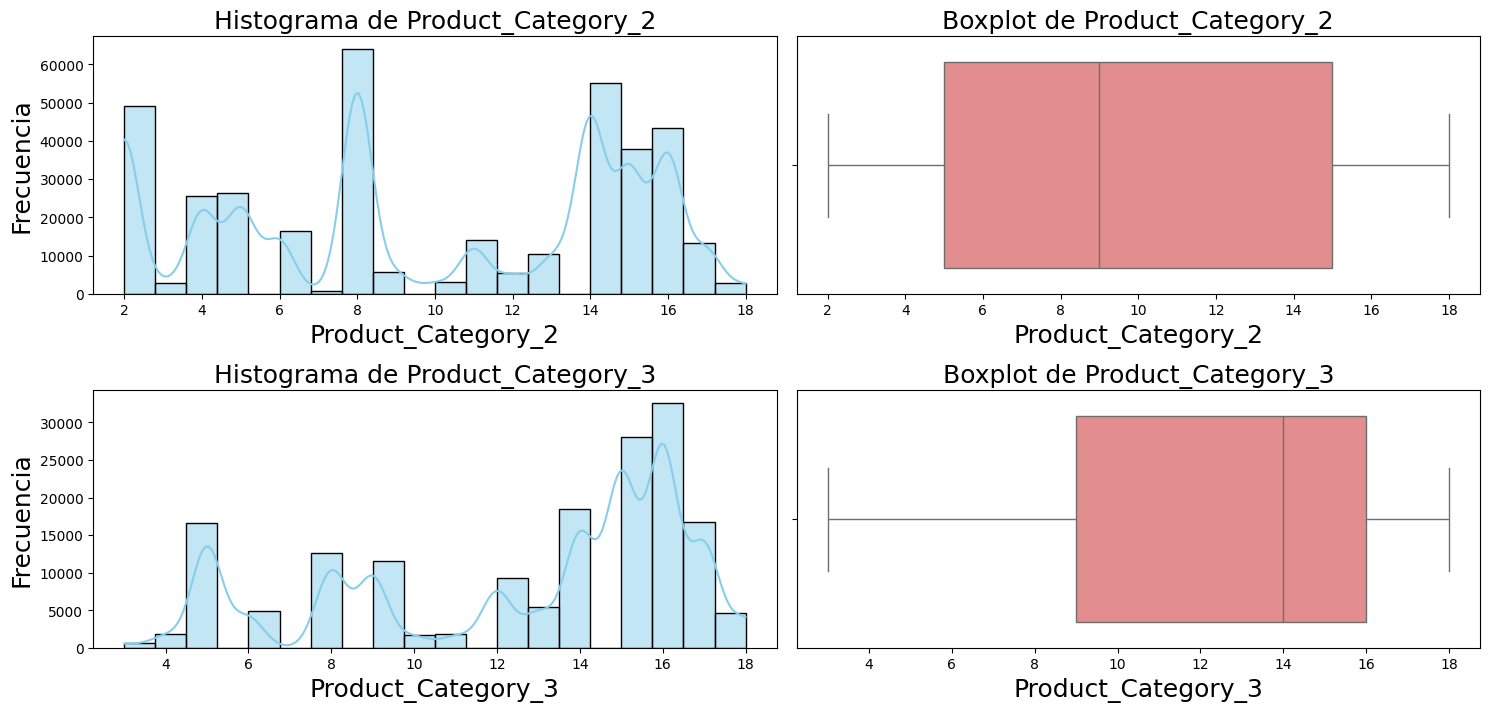

In [137]:
pyplot.figure(figsize=(15, 35))

for i, variable in enumerate(columns_with_missing_values, 1):
    pyplot.subplot(10, 2, i*2-1)
    seaborn.histplot(sales_df[variable], bins=20, kde=True, color='skyblue')
    pyplot.title(f'Histograma de {variable}', fontsize=18)
    pyplot.xlabel(variable, fontsize=18)
    pyplot.ylabel('Frecuencia', fontsize=18)

    pyplot.subplot(10, 2, i*2)
    seaborn.boxplot(x=sales_df[variable], color='lightcoral')
    pyplot.title(f'Boxplot de {variable}', fontsize=18)
    pyplot.xlabel(variable, fontsize=18)

pyplot.subplots_adjust(hspace=0.6)

pyplot.tight_layout()
pyplot.show()


Dado que las columnas no tienen una distribución normal, se procede a imputar los valores nulos respecto a la mediana.

In [138]:
imp_mean = SimpleImputer(missing_values=numpy.nan, strategy='median')

cleaned_sales[columns_with_missing_values] = imp_mean.fit_transform(sales_df[columns_with_missing_values]).astype('int64')

print(cleaned_sales[columns_with_missing_values].head())

   Product_Category_2  Product_Category_3
0                   9                  14
1                   6                  14
2                   9                  14
3                  14                  14
4                   9                  14


Categorización ordinal de la variable objetivo `Purchase`.

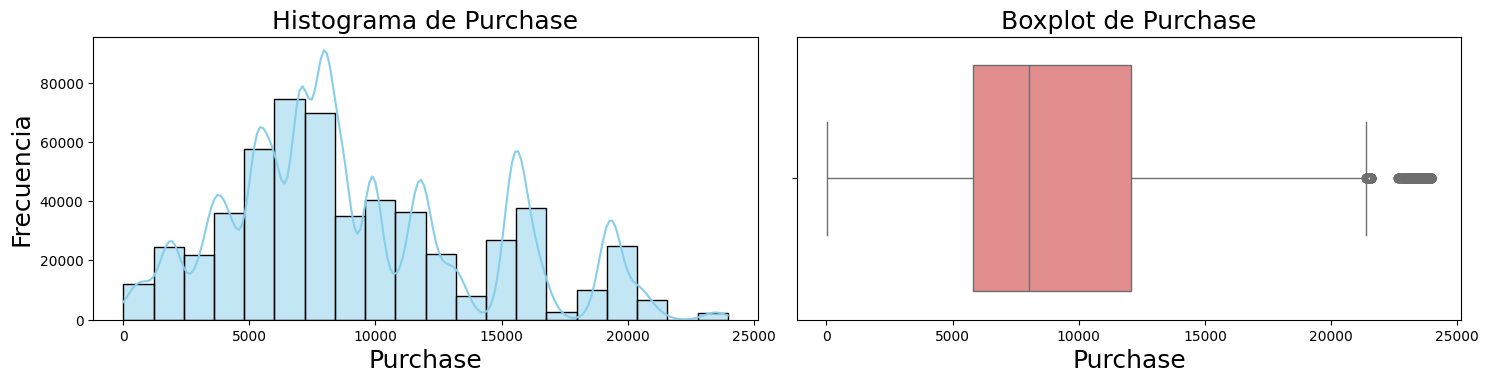

In [139]:
pyplot.figure(figsize=(15, 35))

for i, variable in enumerate(['Purchase'], 1):
    pyplot.subplot(10, 2, i*2-1)
    seaborn.histplot(sales_df[variable], bins=20, kde=True, color='skyblue')
    pyplot.title(f'Histograma de {variable}', fontsize=18)
    pyplot.xlabel(variable, fontsize=18)
    pyplot.ylabel('Frecuencia', fontsize=18)

    pyplot.subplot(10, 2, i*2)
    seaborn.boxplot(x=sales_df[variable], color='lightcoral')
    pyplot.title(f'Boxplot de {variable}', fontsize=18)
    pyplot.xlabel(variable, fontsize=18)

pyplot.subplots_adjust(hspace=0.6)

pyplot.tight_layout()
pyplot.show()

In [140]:
min_valor = sales_df['Purchase'].min()
max_valor = sales_df['Purchase'].max()
media = sales_df['Purchase'].mean()
mediana = sales_df['Purchase'].median()

print(f"Mínimo: {min_valor}")
print(f"Máximo: {max_valor}")
print(f"Media: {media}")
print(f"Mediana: {mediana}")

Mínimo: 12
Máximo: 23961
Media: 9263.968712959126
Mediana: 8047.0


Definimos los grupos de categorización en base a los cuartiles de la columna.

In [141]:
percentiles = sales_df["Purchase"].quantile([0.25, 0.5, 0.75])

print(percentiles)

cleaned_sales["Purchase"] = pandas.cut(
    sales_df["Purchase"],
    bins=[
        0,
        percentiles[0.25],
        percentiles[0.5],
        percentiles[0.75],
        sales_df["Purchase"].max(),
    ],
    labels=["bajo", "medio-bajo", "medio-alto", "alto"],
)
cleaned_sales["Purchase"] = cleaned_sales["Purchase"].cat.codes.astype("int64")

0.25     5823.0
0.50     8047.0
0.75    12054.0
Name: Purchase, dtype: float64


In [164]:
cleaned_sales["Purchase"].value_counts()


Purchase
1    137595
0    137547
3    137479
2    137447
Name: count, dtype: int64

In [142]:
column_types = cleaned_sales.dtypes
uniques = cleaned_sales.nunique()

column_summary = pandas.concat([column_types, uniques], axis=1, keys=["dtype", "uniques"])

print(column_summary)

                            dtype  uniques
User_ID                     int64     5891
Product_ID                  int64     3631
Gender                      int64        2
Age                         int64        7
Occupation                  int64       21
City_Category               int64        3
Stay_In_Current_City_Years  int64        5
Marital_Status              int64        2
Product_Category_1          int64       20
Product_Category_2          int64       17
Product_Category_3          int64       15
Purchase                    int64        4


Con el DataFrame ya procesado a una matriz de valores enteros, procedemos a almacenarlo en el directorio de trabajo para luego utilizarlo para entrenar modelos.

In [143]:
cleaned_sales

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,69042,0,0,10,0,2,0,3,9,14,2
1,1000001,248942,0,0,10,0,2,0,1,6,14,3
2,1000001,87842,0,0,10,0,2,0,12,9,14,0
3,1000001,85442,0,0,10,0,2,0,12,14,14,0
4,1000002,285442,1,6,16,2,4,0,8,9,14,1
...,...,...,...,...,...,...,...,...,...,...,...,...
550063,1006033,372445,1,5,13,1,1,1,20,9,14,0
550064,1006035,375436,0,2,1,2,3,0,20,9,14,0
550065,1006036,375436,0,2,15,1,4,1,20,9,14,0
550066,1006038,375436,0,6,1,2,2,0,20,9,14,0


In [144]:
cleaned_sales = cleaned_sales.drop(['User_ID', 'Product_ID'], axis=1)
cleaned_sales

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,0,0,10,0,2,0,3,9,14,2
1,0,0,10,0,2,0,1,6,14,3
2,0,0,10,0,2,0,12,9,14,0
3,0,0,10,0,2,0,12,14,14,0
4,1,6,16,2,4,0,8,9,14,1
...,...,...,...,...,...,...,...,...,...,...
550063,1,5,13,1,1,1,20,9,14,0
550064,0,2,1,2,3,0,20,9,14,0
550065,0,2,15,1,4,1,20,9,14,0
550066,0,6,1,2,2,0,20,9,14,0


Se guarda el DataFrame limpio como binario en el directorio

In [171]:
cleaned_sales.to_pickle("sales.pkl")

# Entrenamiento de modelos

In [146]:
sales_train_data = pandas.read_pickle("sales.pkl")

## División del dataset

In [147]:
y = sales_train_data.Purchase
X = sales_train_data.drop('Purchase',axis = 1)

In [148]:
normalizer = Normalizer()

X_normalized = normalizer.fit_transform(X)

In [165]:
RANDOM_STATE = 42

X_train, X_temp, y_train, y_temp = train_test_split(X_normalized, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

# División de temp en validation (50%) y test (50%), es decir, 10% del total cada uno.
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp)

# Verificar tamaños
print(f'Train: {len(X_train)}')
print(f'Train: {len(y_train)}')
print(f'Validation: {len(X_val)}')
print(f'Validation: {len(y_val)}')
print(f'Test: {len(X_test)}')
print(f'Test: {len(y_test)}')

Train: 440054
Train: 440054
Validation: 55007
Validation: 55007
Test: 55007
Test: 55007


### Modelo Baseline

Entrenamiento y evaluación de modelo de Regresión Logística como modelo de base para utilizar sus benchamarks como referencia.

In [151]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')
lr_clf.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

Elegimos el Valor-F (F1 score) como métrica para evaluación de los modelos porque proporciona un equilibrio entre la precisión y la recuperación (recall), dos métricas fundamentales en la evaluación de modelos de clasificación multiclase.

In [157]:
def metricas(a, b):
  print(f"Accuracy: %.4f" % (accuracy_score(a, b)), '\n'
        f"Presicion: %.4f" % (precision_score(a, b,  average='weighted', labels=numpy.unique(b))), '\n'
        f"Recall: %.4f" % (recall_score(a, b,  average='weighted', labels=numpy.unique(b))), '\n'
        f"F1: %.4f" % (f1_score(a, b,  average='weighted', labels=numpy.unique(b))), '\n')

In [ ]:
y_train_predict = lr_clf.predict(X_train)
metricas(y_train, y_train_predict)

Accuracy: 0.3900 
Presicion: 0.3647 
Recall: 0.3900 
F1: 0.3667 



In [156]:
y_val_pred =  lr_clf.predict(X_val)
metricas(y_val, y_val_pred)

Accuracy: 0.3889 
Presicion: 0.3639 
Recall: 0.3889 
F1: 0.3660 



## Red Neuronal Multicapa (MLP)

In [160]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [43]:
# Convertir datos a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values.ravel(), dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values.ravel(), dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values.ravel(), dtype=torch.long).to(device)

In [44]:
batch_size = 64

# Crear conjuntos de datos y DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Arquitectura de la red

In [169]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return self.fc4(x)

input_size = X_train.shape[1]
output_size = len(numpy.unique(y_train))
model = MLP(input_size, output_size).to(device)

In [170]:
model

MLP(
  (fc1): Linear(in_features=9, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=4, bias=True)
  (relu): ReLU()
)

In [161]:
class_counts = y_train.value_counts().to_list()
total_samples = sum(class_counts)
weights = torch.tensor([total_samples / c for c in class_counts], dtype=torch.float32).to(device)

* class_counts es la cantidad de muestras por cada clase en y_train.
* weights es un Tensor que contiene un peso inversamente proporcional a la cantidad de muestras en cada clase

Si una clase tiene menos muestras, su peso será mayor, lo que obliga al modelo a prestarle más atención.

El parámetro `weight` en la función de pérdida `CrossEntropyLoss` hace que las clases menos representadas tengan un mayor impacto en la penalización.
Esto reduce el sesgo del modelo hacia la clase mayoritaria y ayuda a mejorar la predicción de clases minoritarias.

In [ ]:
loss_function = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)  # penalty

Entrenamiento

In [ ]:
epochs = 40
train_loss_by_epoch = []
valid_loss_by_epoch = []
train_metric_by_epoch = []
valid_metric_by_epoch = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    epoch_y, epoch_y_hat = [], []

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        mlp_output = model(x_batch)

        loss = loss_function(mlp_output, y_batch)
        loss.backward()
        optimizer.step()

        epoch_y.extend(y_batch.cpu().numpy())
        epoch_y_hat.extend(torch.argmax(mlp_output, dim=1).cpu().numpy())
        epoch_loss += loss.item()

    train_loss_by_epoch.append(epoch_loss / len(train_loader))
    train_metric_by_epoch.append(f1_score(epoch_y, epoch_y_hat, average='weighted'))

    # Validación
    model.eval()
    valid_epoch_loss = 0
    valid_epoch_y, valid_epoch_y_hat = [], []

    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            mlp_output = model(x_batch)
            loss = loss_function(mlp_output, y_batch)

            valid_epoch_y.extend(y_batch.cpu().numpy())
            valid_epoch_y_hat.extend(torch.argmax(mlp_output, dim=1).cpu().numpy())
            valid_epoch_loss += loss.item()

    valid_loss_by_epoch.append(valid_epoch_loss / len(val_loader))
    valid_metric_by_epoch.append(f1_score(valid_epoch_y, valid_epoch_y_hat, average='weighted'))

    print(f" Epoch {epoch} | "
          f"Train/Val loss: {train_loss_by_epoch[-1]:.3f} / {valid_loss_by_epoch[-1]:.3f} | "
          f"Train/Val F1-score: {train_metric_by_epoch[-1]:.3f} / {valid_metric_by_epoch[-1]:.3f}")


 Epoch 0 | Train/Val loss: 1.330 / 1.254 | Train/Val F1-score: 0.326 / 0.330
 Epoch 1 | Train/Val loss: 1.242 / 1.231 | Train/Val F1-score: 0.370 / 0.369
 Epoch 2 | Train/Val loss: 1.214 / 1.193 | Train/Val F1-score: 0.398 / 0.402
 Epoch 3 | Train/Val loss: 1.174 / 1.165 | Train/Val F1-score: 0.424 / 0.416
 Epoch 4 | Train/Val loss: 1.162 / 1.162 | Train/Val F1-score: 0.415 / 0.423
 Epoch 5 | Train/Val loss: 1.159 / 1.159 | Train/Val F1-score: 0.414 / 0.417
 Epoch 6 | Train/Val loss: 1.155 / 1.154 | Train/Val F1-score: 0.417 / 0.418
 Epoch 7 | Train/Val loss: 1.151 / 1.147 | Train/Val F1-score: 0.422 / 0.424
 Epoch 8 | Train/Val loss: 1.144 / 1.137 | Train/Val F1-score: 0.431 / 0.426
 Epoch 9 | Train/Val loss: 1.131 / 1.120 | Train/Val F1-score: 0.440 / 0.437
 Epoch 10 | Train/Val loss: 1.112 / 1.096 | Train/Val F1-score: 0.449 / 0.459
 Epoch 11 | Train/Val loss: 1.087 / 1.085 | Train/Val F1-score: 0.467 / 0.459
 Epoch 12 | Train/Val loss: 1.068 / 1.050 | Train/Val F1-score: 0.478 / 0.

### Gráficos

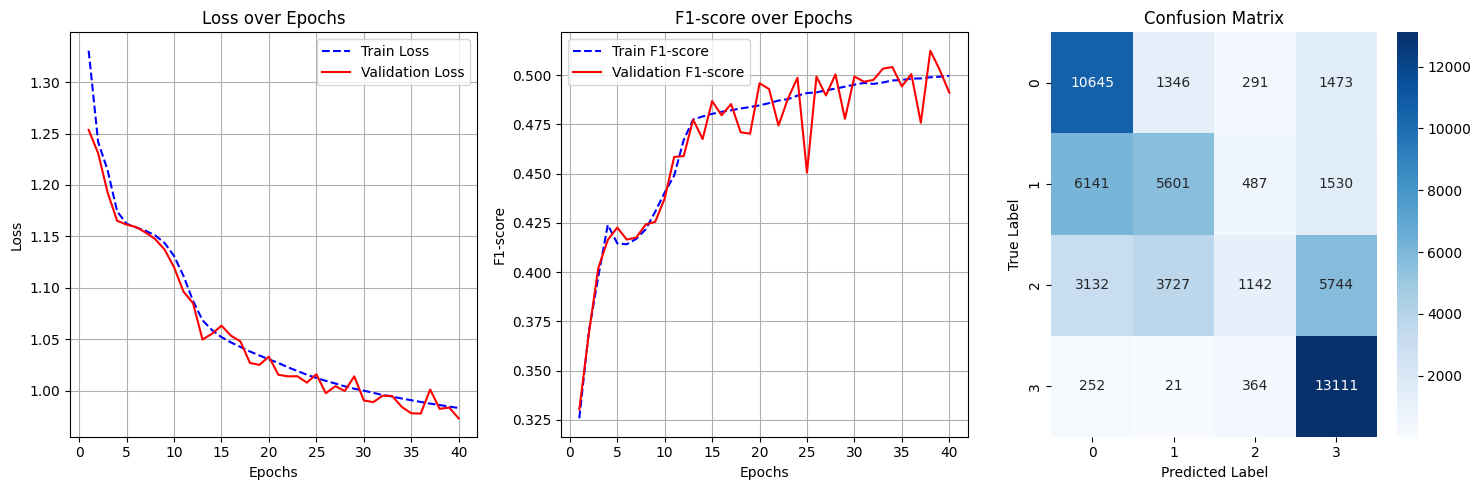

In [ ]:
conf_matrix = confusion_matrix(valid_epoch_y, valid_epoch_y_hat)

# subplots
fig, axes = pyplot.subplots(1, 3, figsize=(15, 5))

# Loss
axes[0].plot(range(1, epochs + 1), train_loss_by_epoch, label="Train Loss", color='blue', linestyle='--')
axes[0].plot(range(1, epochs + 1), valid_loss_by_epoch, label="Validation Loss", color='red')
axes[0].set_title("Loss over Epochs")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid()

# F1-score
axes[1].plot(range(1, epochs + 1), train_metric_by_epoch, label="Train F1-score", color='blue', linestyle='--')
axes[1].plot(range(1, epochs + 1), valid_metric_by_epoch, label="Validation F1-score", color='red')
axes[1].set_title("F1-score over Epochs")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("F1-score")
axes[1].legend()
axes[1].grid()

# Matriz de Confusión
seaborn.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[2])
axes[2].set_title("Confusion Matrix")
axes[2].set_xlabel("Predicted Label")
axes[2].set_ylabel("True Label")

pyplot.tight_layout()
pyplot.show()

# Conclusiones

Al analizar la matriz de confusión del modelo, se pueden realizar las siguientes observaciones:

Mientras que el modelo realiza buenas predicciones para las clases extremas (clase 0, monto bajo; clase 3, monto alto), para las clases intermedias (clase 1, medio-bajo; clase 2, medio-alto) se presenta una alta confusión con otras clases, lo que indica que el modelo tiene dificultades para distinguir montos medios.

Estas confuciones (tanto para las clases extremas como intermedias) ocurren principalmente con clases vecinas. Por ejemplo, la clase 2 se predice como 1 en 3,727 casos y como 3 en 5,744 casos.

Esto sugiere que la representación de los montos medios (clases 1 y 2) no está bien diferenciada en el espacio de características.

Teniendo en cuenta que la discretización de la variable continua "Purchase" se realizó definiendo los límites entre las clases utilizando los percentiles 25%, 50% y 75%, los valores de la variable y sus rangos quedaron de la siguiente manera:

| Mínimo | P25   | P50   | P75    | Máximo |
|--------|-------|-------|--------|--------|
| 12     | 5.823 | 8.047 | 12.054 | 23.961 |

Lo que dio lugar a las siguientes cuatro categorías de los valores de "Purchase":

* Bajo (0): 12 a 5.823
* Medio-bajo (1): 5.823 a 8.047
* Medio-alto (2): 8.047 a 12.054
* Alto (3): 12.054 a 23.961

Al observar el tamaño de los intervalos, se nota que las clases intermedias (1 y 2) son más pequeñas en comparación con las categorías extremas, que abarcan rango mayores. Además, las diferencias entre los valores en las clases 1 y 2 son relativamente pequeñas, lo que podría estar dificultando la diferenciación entre ellas durante el entrenamiento del modelo.

Esto puede explicar la alta confusión en la clasificación de las clases intermedias, ya que los valores de "Purchase" en estos rangos están muy próximos y no presentan una separación clara en el espacio de características del modelo. También explica el buen desempeño del modelo para clasificar elementos de la categoría "Alto", ya que esta es la clase con el rango más amplio.

Es importante notar también que la categorización de la variable objetivo se realizó de manera progresiva, asignando etiquetas numéricas de menor a mayor según el monto de compra.

Dado que estos valores representan niveles de compra en una escala lineal, el modelo aprende que existe un orden inherente entre las clases. Sin embargo, al tratar la variable categorizada forma puramente lineal sin considerar la diferencia de escala entre los rangos de las clases, el modelo no necesariamente aprende que la diferencia entre 1 y 2 es menor que la diferencia entre 2 y 3.

Esta falta de información sobre las escalas de las clases puede ser una de las razones por las que el modelo tiene dificultades en la distinción de los montos intermedios, y explicaría la confusión observada en la matriz de confusión.


## Posibles mejoras

Para mejorar la capacidad del modelo en la clasificación de montos intermedios, se pueden considerar las siguientes estrategias:

Revisión de la discretización: Ajustar los umbrales de las clases para equilibrar mejor los tamaños de los intervalos y reducir la superposición entre los montos intermedios. Se podría explorar el uso de técnicas como clustering (por ejemplo, k-means) para definir las categorías de manera más representativa.

Uso de técnicas de reescalado: Dado que la variable objetivo tiene una estructura ordinal, se podría aplicar técnicas de codificación que preserven mejor las relaciones entre las clases, como la codificación ordinal o embeddings específicos para datos categóricos ordenados.

Modelos con sensibilidad a la estructura ordinal: Explorar algoritmos que consideren la naturaleza ordinal de la variable objetivo, como regresión ordinal, modelos basados en árboles con pérdida específica para clasificación ordinal o redes neuronales con salidas ordenadas.